# Работа с датасетом "Spotify"

In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

df = pd.read_csv(r"C:\Users\ASUS\Downloads\dataset.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head()


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4.0,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4.0,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4.0,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3.0,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4.0,acoustic


## Основные метаданные
**track_id** – уникальный идентификатор трека в Spotify  
**artists** – исполнитель(и) трека  
**album_name** – название альбома  
**track_name** – название трека  
**popularity** – популярность трека от 0 до 100 (чем выше, тем популярнее)  
**duration_ms** – длительность трека в миллисекундах  
**explicit** – содержит ли трек нецензурную лексику (True/False)  
**danceability** – танцевальность от 0.0 до 1.0 (чем выше, тем лучше для танцев)  
**energy** – энергетичность от 0.0 (спокойный) до 1.0 (энергичный)  
**key** – тональность в формате Pitch Class (0=C, 1=C#/Db, ..., 11=B)  
**loudness** – громкость в децибелах (обычно от -60 до 0 дБ)  
**mode** – лад: 1 = мажор, 0 = минор  
**speechiness** – наличие разговорной речи (0.0–1.0, выше 0.66 – вероятно рэп или подкаст)  
**acousticness** – акустичность от 0.0 (электронный) до 1.0 (акустический звук)  
**instrumentalness** – инструментальность: ближе к 1.0 – меньше вокала  
**liveness** – "живость" записи: выше 0.8 – вероятно запись с концерта  
**valence** – позитивность (0.0 = грустный, 1.0 = весёлый)  
**tempo** – темп в BPM (ударах в минуту)  
**time_signature** – музыкальный размер (например, 4 = 4/4)  
**track_genre** – жанр трека (в этом датасете все треки – acoustic)


## Работа с пропусками и аномальными значениями

### Количество пропусков

In [112]:
df.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         1
energy_dance        0
tempo_bin           0
loudness_abs        0
dtype: int64

In [57]:
for col in df.select_dtypes(include=np.number):
    df[col] = df[col].fillna(df[col].median())

### Проверка аномальных значений

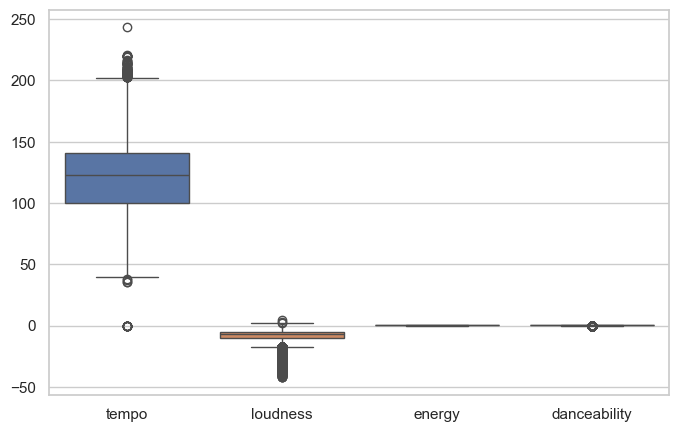

In [58]:
sns.boxplot(data=df[['tempo','loudness','energy','danceability']])
plt.show()

In [59]:
df['tempo'] = df['tempo'].clip(
    lower=df['tempo'].quantile(0.01),
    upper=df['tempo'].quantile(0.99)
)

df['loudness'] = df['loudness'].clip(
    lower=df['loudness'].quantile(0.01),
    upper=df['loudness'].quantile(0.99)
)

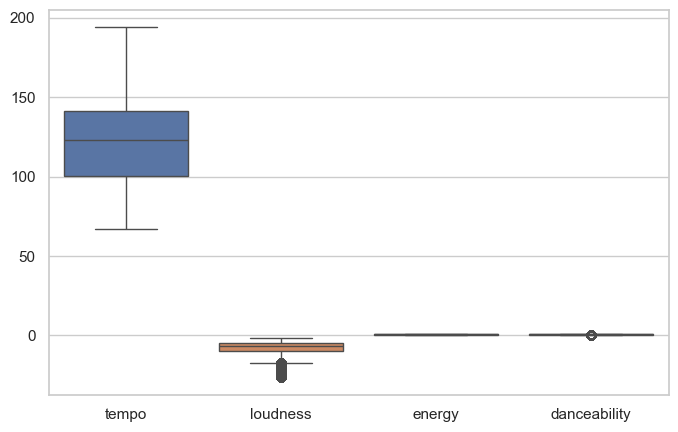

In [60]:
sns.boxplot(data=df[['tempo', 'loudness', 'energy', 'danceability']])
plt.show()

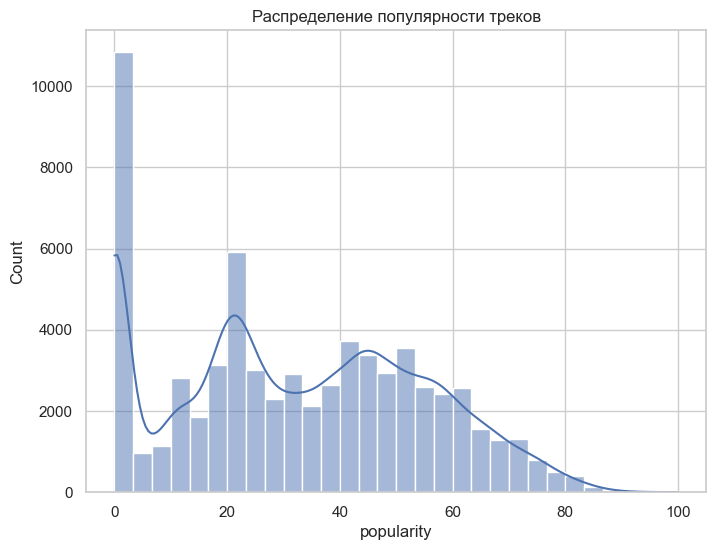

In [61]:
plt.figure(figsize=(8,6))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title('Распределение популярности треков')
plt.show()

## Гипотезы

### Популярность зависить от энергичности трека

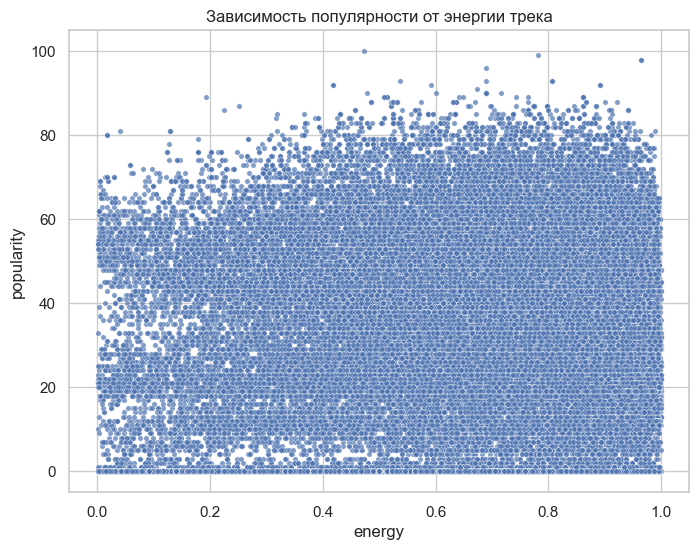

In [62]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='energy',
    y='popularity',
    data=df,
    s=15,
    alpha=0.7
)
plt.title('Зависимость популярности от энергии трека')
plt.show()

In [63]:
df[['energy','popularity']].corr()

,energy,popularity
energy,1.00000,-0.00542
popularity,-0.00542,1.00000


Гипотеза не подтверждается

### Популярность зависит от танцевальности трека

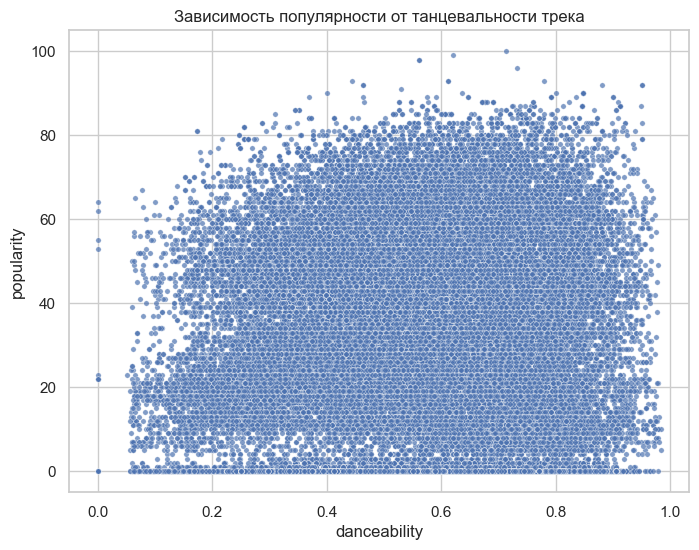

In [64]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='danceability',
    y='popularity',
    data=df,
    s=15,
    alpha=0.7
)
plt.title('Зависимость популярности от танцевальности трека')
plt.show()

In [65]:
df[['danceability','popularity']].corr()

,danceability,popularity
danceability,1.000000,0.065807
popularity,0.065807,1.000000


In [ ]:
Гипотеза подтвеждается

### Популярность зависит от акустичности трека

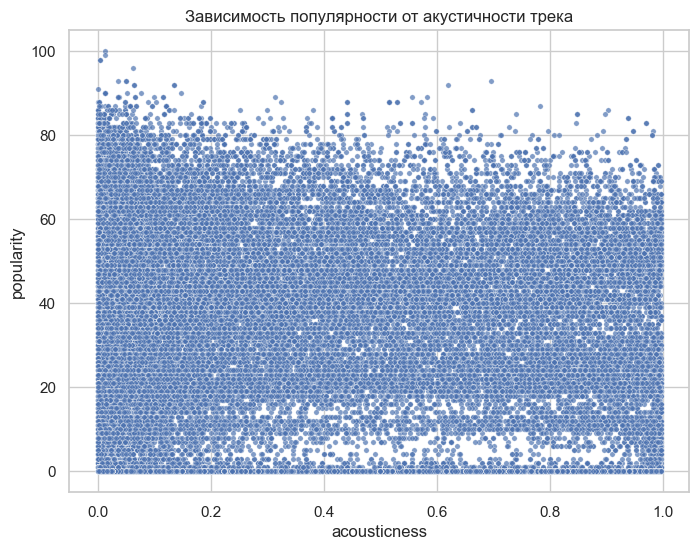

In [66]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='acousticness',
    y='popularity',
    data=df,
    s=15,
    alpha=0.7
)
plt.title('Зависимость популярности от акустичности трека')
plt.show()

In [67]:
df[['acousticness','popularity']].corr()

,acousticness,popularity
acousticness,1.000000,-0.015122
popularity,-0.015122,1.000000


Гипотеза не подтверждается

### Корреляция популярности с параметрами 

In [68]:
corr = (
    df
    .select_dtypes(include='number')
    .corr()['popularity']
    .sort_values(ascending=False)
)

corr


popularity          1.000000
loudness            0.103104
danceability        0.065807
time_signature      0.034591
tempo               0.008153
key                 0.001220
energy             -0.005420
valence            -0.012591
acousticness       -0.015122
mode               -0.028708
liveness           -0.031872
duration_ms        -0.038253
speechiness        -0.044781
instrumentalness   -0.158937
Name: popularity, dtype: float64

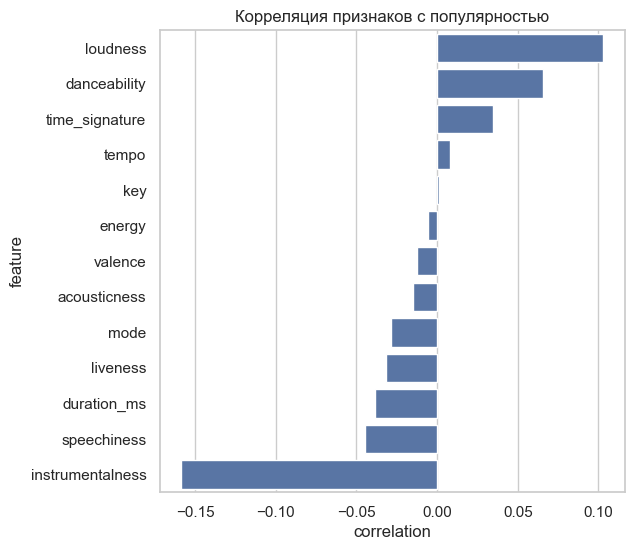

In [69]:
corr_df = corr.drop('popularity').reset_index()
corr_df.columns = ['feature', 'correlation']

plt.figure(figsize=(6, 6))
sns.barplot(
    data=corr_df,
    x='correlation',
    y='feature'
)
plt.title('Корреляция признаков с популярностью')
plt.show()


## FEATURE ENGINEERING

### Перевод времени в минуты

In [ ]:
df['duration_min'] = df['duration_ms'] / 60000 

### Темповая категория

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22156\230754308.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tempo_category', y='popularity', data=df, palette='coolwarm')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22156\230754308.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = df.groupby('tempo_category')['popularity'].mean()


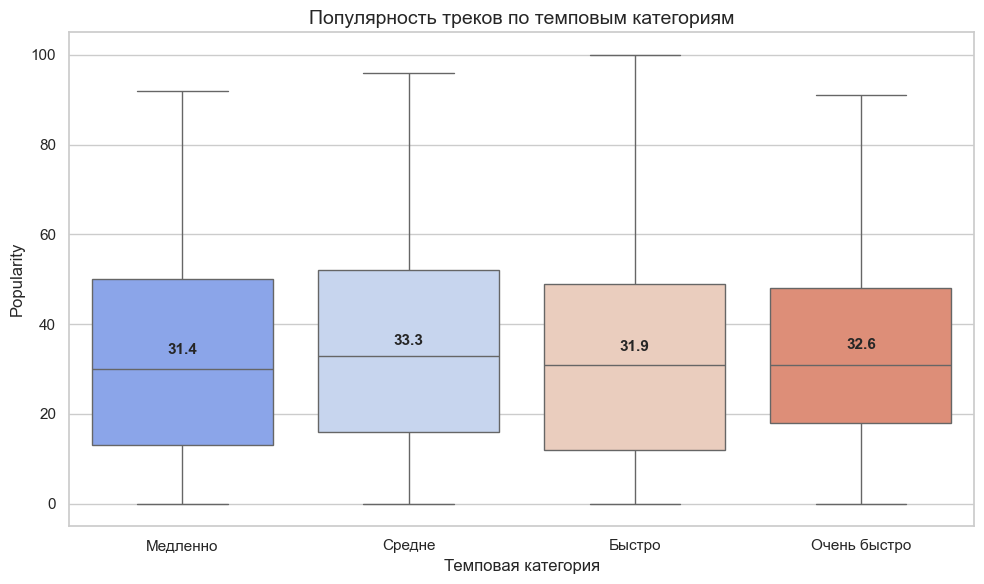

In [144]:
bins = [60, 90, 120, 150, 300]
labels = ['Медленно', 'Средне', 'Быстро', 'Очень быстро']
df['tempo_category'] = pd.cut(df['tempo'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.boxplot(x='tempo_category', y='popularity', data=df, palette='coolwarm')
plt.xlabel('Темповая категория', fontsize=12)
plt.ylabel('Popularity', fontsize=12)
plt.title('Популярность треков по темповым категориям', fontsize=14)

category_means = df.groupby('tempo_category')['popularity'].mean()
for i, category in enumerate(labels):
    mean_val = category_means[category]
    plt.text(i, mean_val + 2, f'{mean_val:.1f}', 
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### Профессиональность

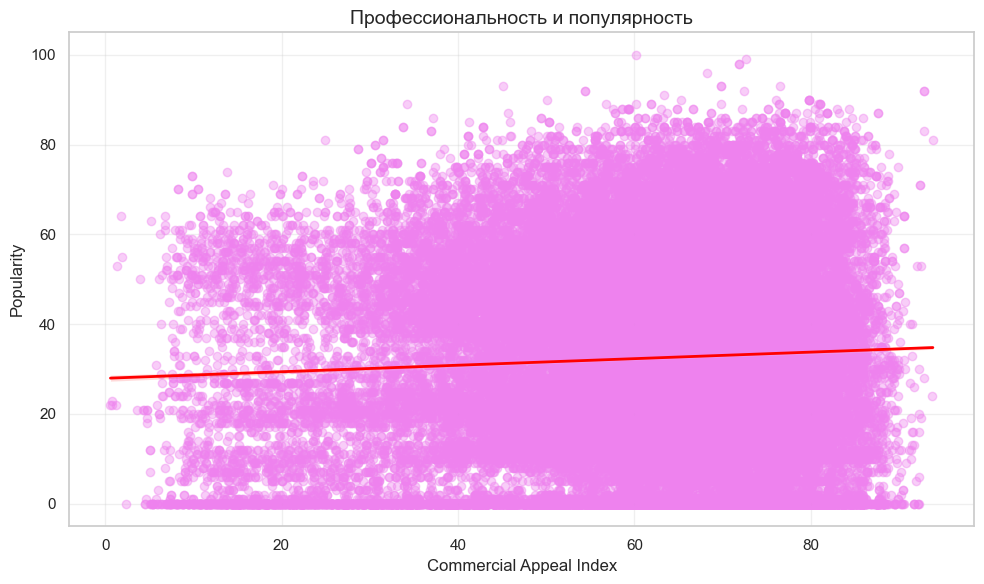

In [151]:
df['commercial_appeal'] = (
    (df['danceability'] * 0.3) + 
    (df['energy'] * 0.3) + 
    (df['valence'] * 0.2) + 
    ((1 - df['acousticness']) * 0.1) + 
    ((1 - df['instrumentalness']) * 0.1)
) * 100

plt.figure(figsize=(10, 6))
sns.regplot(x='commercial_appeal', y='popularity', data=df, 
            scatter_kws={'alpha': 0.4, 'color': 'violet'},
            line_kws={'color': 'red', 'linewidth': 2})

plt.xlabel('Commercial Appeal Index', fontsize=12)
plt.ylabel('Popularity', fontsize=12)
plt.title('Профессиональность и популярность', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Эмоциональный профиль 

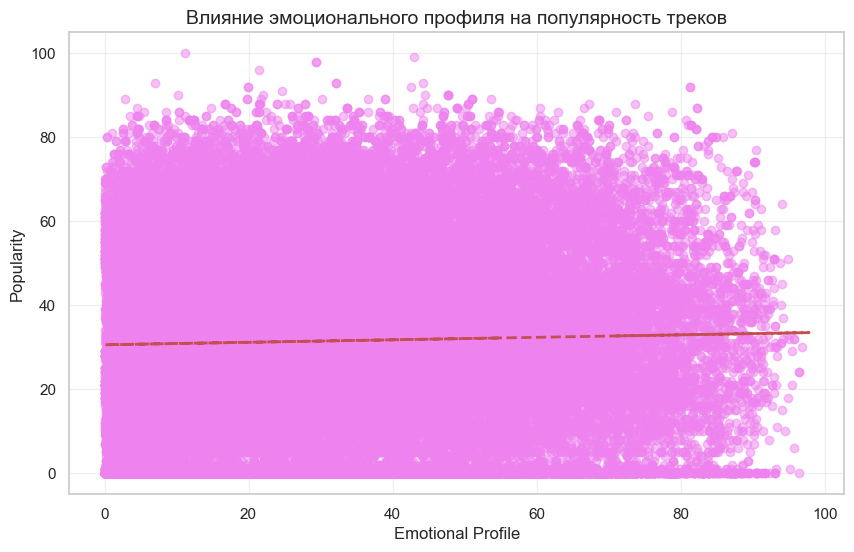

In [148]:
df['emotional_profile'] = df['valence'] * df['energy'] * 100

plt.figure(figsize=(10, 6))
plt.scatter(df['emotional_profile'], df['popularity'], alpha=0.5, color='violet')
plt.xlabel('Emotional Profile', fontsize=12)
plt.ylabel('Popularity', fontsize=12)
plt.title('Влияние эмоционального профиля на популярность треков', fontsize=14)
plt.grid(True, alpha=0.3)


z = np.polyfit(df['energy_dance_score'], df['popularity'], 1)
p = np.poly1d(z)
plt.plot(df['energy_dance_score'], p(df['energy_dance_score']), "r--", linewidth=2)

plt.show()

### Энергетическая танцевальность 

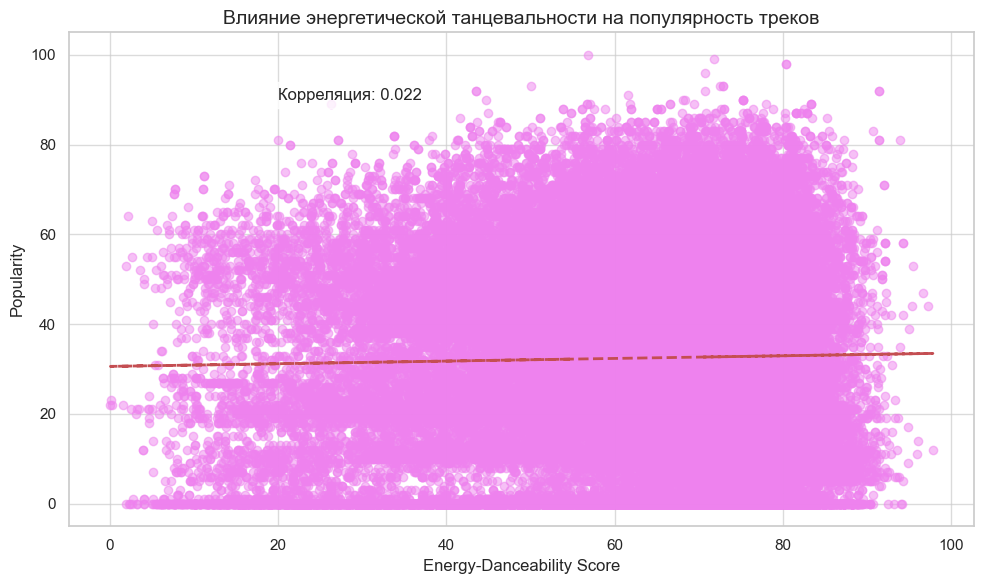

In [149]:
df['energy_dance_score'] = (df['energy'] * 0.6 + df['danceability'] * 0.4) * 100

plt.figure(figsize=(10, 6))
plt.scatter(df['energy_dance_score'], df['popularity'], alpha=0.5, color='violet')
plt.xlabel('Energy-Danceability Score', fontsize=12)
plt.ylabel('Popularity', fontsize=12)
plt.title('Влияние энергетической танцевальности на популярность треков', fontsize=14)
plt.grid(True, alpha=0.7)

z = np.polyfit(df['energy_dance_score'], df['popularity'], 1)
p = np.poly1d(z)
plt.plot(df['energy_dance_score'], p(df['energy_dance_score']), "r--", linewidth=2)

corr = df['energy_dance_score'].corr(df['popularity'])
plt.text(20, 90, f'Корреляция: {corr:.3f}', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

КОРРЕЛЯЦИЯ ФИЧ С ПОПУЛЯРНОСТЬЮ
                Фича  Корреляция с популярностью            Тип  abs_correlation
 acoustic_uniqueness                   -0.173536       числовая         0.173536
radio_duration_score                    0.079875       числовая         0.079875
    climax_intensity                   -0.065947       числовая         0.065947
   commercial_appeal                    0.050957       числовая         0.050957
        duration_min                   -0.038253       числовая         0.038253
      tempo_category                    0.027440 категориальная         0.027440
  energy_dance_score                    0.022363       числовая         0.022363
       balance_score                    0.014456       числовая         0.014456
   emotional_profile                   -0.004822       числовая         0.004822


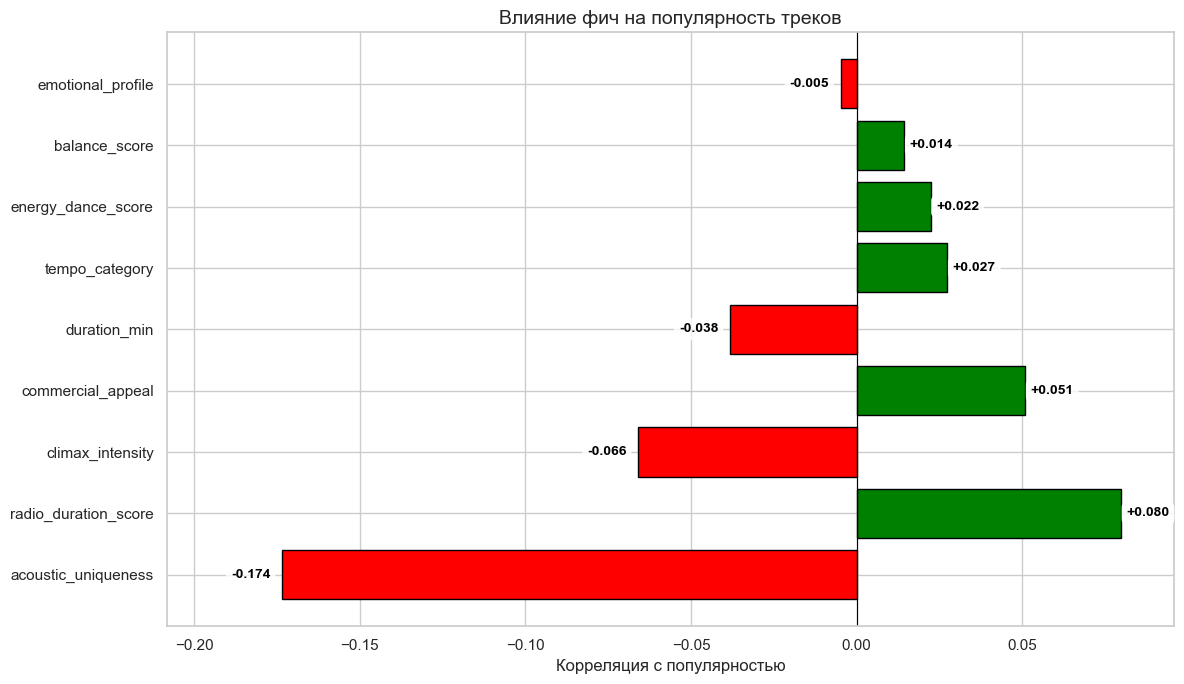


ИНТЕРПРЕТАЦИЯ КОРРЕЛЯЦИЙ
➖ acoustic_uniqueness      : -0.174 (уменьшает популярность)
➖ radio_duration_score     : +0.080 (слабо влияет на популярность)
➖ climax_intensity         : -0.066 (слабо влияет на популярность)
➖ commercial_appeal        : +0.051 (слабо влияет на популярность)
➖ duration_min             : -0.038 (слабо влияет на популярность)
➖ tempo_category           : +0.027 (слабо влияет на популярность)
➖ energy_dance_score       : +0.022 (слабо влияет на популярность)
➖ balance_score            : +0.014 (слабо влияет на популярность)
➖ emotional_profile        : -0.005 (слабо влияет на популярность)


In [166]:
df['radio_duration_score'] = ((df['duration_min'] >= 3) & (df['duration_min'] <= 4)).astype(int)

df['balance_score'] = (df['danceability'] + df['energy'] + df['valence']) / 3

df['climax_intensity'] = df['loudness'] * df['energy'] * (1 - df['instrumentalness'])

df['acoustic_uniqueness'] = (
    abs(df['acousticness'] - 0.3) +  
    abs(df['instrumentalness'] - 0.1) + 
    abs(df['speechiness'] - 0.05)  
)

all_features = ['duration_min', 'tempo_category', 'commercial_appeal', 
                'emotional_profile', 'energy_dance_score',
                'radio_duration_score', 'balance_score', 'climax_intensity', 'acoustic_uniqueness']
correlations = {}
for feature in all_features:
    if df[feature].dtype == 'category':
        category_means = df.groupby(feature)['popularity'].mean()
        correlations[feature] = category_means.std() / df['popularity'].std()
    else:
        correlations[feature] = df[feature].corr(df['popularity'])

correlation_df = pd.DataFrame({
    'Фича': correlations.keys(),
    'Корреляция с популярностью': correlations.values(),
    'Тип': ['числовая' if df[f].dtype != 'category' else 'категориальная' for f in correlations.keys()]
})

correlation_df['abs_correlation'] = correlation_df['Корреляция с популярностью'].abs()
correlation_df = correlation_df.sort_values('abs_correlation', ascending=False)

print("="*70)
print("КОРРЕЛЯЦИЯ ФИЧ С ПОПУЛЯРНОСТЬЮ")
print("="*70)
print(correlation_df.to_string(index=False))

plt.figure(figsize=(12, 7))

min_corr = correlation_df['Корреляция с популярностью'].min()
max_corr = correlation_df['Корреляция с популярностью'].max()

bars = plt.barh(correlation_df['Фича'], correlation_df['Корреляция с популярностью'], 
                color=['green' if x > 0 else 'red' for x in correlation_df['Корреляция с популярностью']],
                edgecolor='black')

plt.xlabel('Корреляция с популярностью', fontsize=12)
plt.title('Влияние фич на популярность треков', fontsize=14)
plt.axvline(x=0, color='black', linewidth=0.8)

plt.xlim(min_corr * 1.2, max_corr * 1.2)

for bar, value in zip(bars, correlation_df['Корреляция с популярностью']):
    width = bar.get_width()
    
    if width > 0:
        x_position = width + max_corr * 0.02
        ha = 'left'
        color = 'black'
    else:
        x_position = width + min_corr * 0.02
        ha = 'right'
        color = 'black'
    
    plt.text(x_position, bar.get_y() + bar.get_height()/2,
             f'{value:+.3f}', va='center', ha=ha, fontsize=10,
             color=color, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ИНТЕРПРЕТАЦИЯ КОРРЕЛЯЦИЙ")
print("="*70)

for _, row in correlation_df.iterrows():
    corr = row['Корреляция с популярностью']
    feature = row['Фича']
    
    if corr > 0.3:
        effect = "СИЛЬНО УВЕЛИЧИВАЕТ популярность"
    elif corr > 0.1:
        effect = "увеличивает популярность"
    elif corr > -0.1:
        effect = "слабо влияет на популярность"
    elif corr > -0.3:
        effect = "уменьшает популярность"
    else:
        effect = "СИЛЬНО УМЕНЬШАЕТ популярность"
    
    print(f"{emoji} {feature:25s}: {corr:+.3f} ({effect})")

## Обучение моделей

In [72]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack



X = df.drop('popularity', axis=1)
y = df['popularity']

cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(exclude=['object', 'category']).columns

ohe = OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore')
X_cat = ohe.fit_transform(X[cat_cols])
X_num = X[num_cols].fillna(0).astype(np.float32).values
X_sparse = hstack([X_num, X_cat])

X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.2, random_state=42
)

scaler = StandardScaler(with_mean=False) 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



### Линейная регрессия

In [73]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))  # вручную
print("RMSE:", rmse)
print("R2:", r2_score(y_test, pred))


RMSE: 12.839889759792351
R2: 0.6652435092096821


### Древо решений

In [74]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))  # вручную
r2 = r2_score(y_test, pred)

print("RMSE:", rmse)
print("R2:", r2)



RMSE: 18.532975061619286
R2: 0.30257630374799116


### CatBoostRegressor

In [88]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

for col in cat_cols:
    if X[col].dtype.name == 'category':
        if 'missing' not in X[col].cat.categories:
            X[col] = X[col].cat.add_categories('missing')  # добавляем категорию 'missing', если её нет
    X[col] = X[col].fillna('missing')  # заменяем NaN

X[num_cols] = X[num_cols].fillna(0).astype(np.float32)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from catboost import Pool, CatBoostRegressor
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False  
)
model.fit(train_pool)


from sklearn.metrics import mean_squared_error, r2_score
pred = model.predict(test_pool)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print("RMSE:", rmse)
print("R2:", r2)


RMSE: 9.445239039680494
R2: 0.8188525088404932


### MPL

In [113]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

num_cols = X.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42))
])


mlp_pipeline.fit(X_train, y_train)


pred = mlp_pipeline.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("RMSE:", rmse)
print("R2:", r2)



RMSE: 22.41281895487048
R2: -0.01999814654036225


### Вывод: 
Лучшая модель - CatBoostRegressor

## Кросс-валидация

In [164]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from catboost import Pool, CatBoostRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_list = []
r2_list = []
feature_importance_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool = Pool(X_val, y_val, cat_features=cat_cols)

    model = CatBoostRegressor(
        iterations=80,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        verbose=False
    )

    model.fit(train_pool)
    pred = model.predict(val_pool)

    mse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, pred)

    mse_list.append(mse)
    r2_list.append(r2)
    
    importance = model.get_feature_importance()
    feature_importance_list.append(importance)

    print(f"Fold {fold} - RMSE: {mse:.4f}, R2: {r2:.4f}")

print("CV Average RMSE:", np.mean(mse_list))
print("CV Average R2:", np.mean(r2_list))

avg_importance = np.mean(feature_importance_list, axis=0)
feature_names = X.columns

import pandas as pd
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values(by='Importance', ascending=False)

print("\n Важность признаков для популярности (средняя по всем фолдам):")
print(importance_df.head(20)) 


Fold 1 - RMSE: 11.1075, R2: 0.7495
Fold 2 - RMSE: 10.9801, R2: 0.7583
Fold 3 - RMSE: 10.8434, R2: 0.7643
Fold 4 - RMSE: 11.0902, R2: 0.7554
Fold 5 - RMSE: 10.9221, R2: 0.7602
CV Average RMSE: 10.988685811598035
CV Average R2: 0.7575378702383595

 Важность признаков для популярности (средняя по всем фолдам):
             Feature  Importance
2         album_name   58.853377
18       track_genre   24.626644
1            artists    5.072778
0           track_id    2.521664
13  instrumentalness    2.367049
4        duration_ms    1.435281
3         track_name    1.165350
7             energy    0.742655
12      acousticness    0.620149
6       danceability    0.496852
5           explicit    0.338622
11       speechiness    0.331508
19      energy_dance    0.279770
9           loudness    0.266578
21      loudness_abs    0.265439
14          liveness    0.220389
15           valence    0.182761
16             tempo    0.172430
10              mode    0.018368
17    time_signature    0.01757